# **Object Detection(객체 탐지)**
* 컴퓨터 비전과 이미지 처리와 관련된 컴퓨터 기술로써, 디지털 이미지와 비디오로 특정한 계열의 시맨틱 객체 인스턴스를 감지하는 일
* 얼굴 검출, 보행자 검출 등이 포함

# **컴퓨터 비전의 Task비교**
* Image Classification: 이미지에 있는 개체 범주 목록 생성
* Single-Object Localization: 이미지에 있는 개체 범주의 한 인스턴스의 위치와 배율을 나타내는 Bounding Box를 생성
* Object Detection: 각 개체 범주의 모든 인스턴스의 위치와 배율을 나타내는 경계 상자와 함께 이미지에 있는 개체 목록을 생성
* [Object Detection 논문 흐름도](https://oniss.tistory.com/39)

In [1]:
import os
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from ipywidgets import interact
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.utils import make_grid
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from collections import defaultdict
from torchvision.ops import nms
from util import CLASS_NAME_TO_ID, visualize, save_model

In [2]:
data_dir = './datasets/'
data_df = pd.read_csv(os.path.join(data_dir, 'df.csv'))
data_df

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,...,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,...,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24057,fff2b15ad6007d0e,activemil,Truck,1,0.277344,0.622656,0.226389,0.859722,0,0,...,0,0,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
24058,fff376d20410e4c9,xclick,Bus,1,0.295625,0.558750,0.306667,0.397500,1,0,...,1,0,0.424375,0.316250,0.295625,0.558750,0.306667,0.397500,0.382500,0.335833
24059,fff376d20410e4c9,xclick,Bus,1,0.348125,0.701250,0.423333,0.744167,0,0,...,1,0,0.478750,0.493125,0.348125,0.701250,0.423333,0.744167,0.537500,0.523333
24060,fffde5953a818927,xclick,Bus,1,0.277500,0.605625,0.565000,0.795833,0,0,...,0,0,0.488125,0.277500,0.517500,0.605625,0.565000,0.670000,0.795833,0.704167


In [3]:
index = 0
image_files = [fn for fn in os.listdir('./datasets/train/') if fn.endswith('jpg')]
image_file = image_files[index]
image_file

'0000599864fd15b3.jpg'

In [4]:
image_path = os.path.join('./datasets/train/', image_file)
image_path

'./datasets/train/0000599864fd15b3.jpg'

In [64]:
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image.shape


(170, 256, 3)

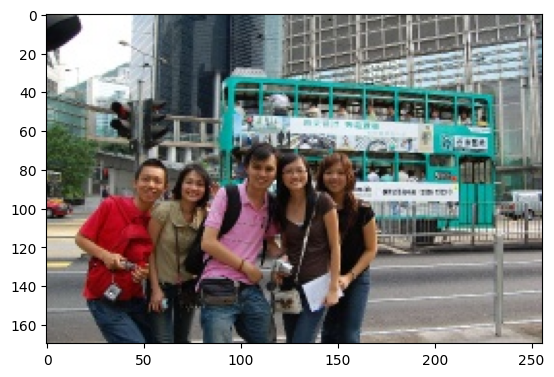

In [6]:
plt.imshow(image)

In [7]:
# 0000599864fd15b3.jpg
image_id = image_file.split('.')[0]
image_id

'0000599864fd15b3'

In [8]:
meta_data = data_df[data_df['ImageID'] == image_id]
meta_data

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.34375,0.90875,0.156162,0.650047,1,0,...,0,0,0.421875,0.34375,0.795,0.90875,0.156162,0.5127,0.650047,0.457197


In [9]:
cate_names = meta_data['LabelName'].values
cate_names

array(['Bus'], dtype=object)

In [10]:
bboxes = meta_data[['XMin', 'XMax', 'YMin', 'YMax']].values
bboxes

array([[0.34375 , 0.90875 , 0.156162, 0.650047]])

In [11]:
img_H, img_W, _ = image.shape
img_H, img_W

(170, 256)

In [12]:
class_ids = [CLASS_NAME_TO_ID[cate_name] for cate_name in cate_names]
class_ids

[0]

In [13]:
unnorm_bboxes = bboxes.copy()
unnorm_bboxes
# XMin, XMax, YMin, YMax

array([[0.34375 , 0.90875 , 0.156162, 0.650047]])

In [14]:
# XMin, XMax, YMin, YMax -> XMin, YMin, XMax, YMax
unnorm_bboxes[:, [1, 2]] = unnorm_bboxes[:, [2, 1]]
unnorm_bboxes

array([[0.34375 , 0.156162, 0.90875 , 0.650047]])

In [15]:
# XMin, YMin, XMax, YMax
# XMax - XMin, YMax - YMin
# XMin, YMin, W, H
unnorm_bboxes[:, 2:4] -= unnorm_bboxes[:, 0:2]
unnorm_bboxes

array([[0.34375 , 0.156162, 0.565   , 0.493885]])

In [16]:
# XMin, YMin, W, H
# XMin, YMin += (W, H / 2)
# XMin + (W/2), YMin + (H/2)
# X_Cen, Y_Cen, W, H
unnorm_bboxes[:, 0:2] += (unnorm_bboxes[:, 2:4]/2)
unnorm_bboxes

array([[0.62625  , 0.4031045, 0.565    , 0.493885 ]])

In [17]:
unnorm_bboxes[:, [0, 2]] *= img_W
unnorm_bboxes[:, [1, 3]] *= img_H
unnorm_bboxes

array([[160.32    ,  68.527765, 144.64    ,  83.96045 ]])

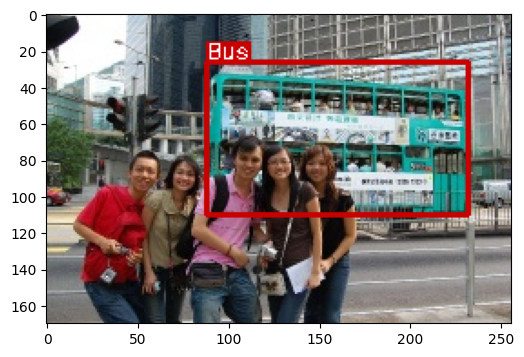

In [18]:
canvas = visualize(image, unnorm_bboxes, class_ids)
plt.figure(figsize=(6, 6))
plt.imshow(canvas)
plt.show()

In [19]:
@interact(index=(0, len(image_files)-1))
def show_sample(index=0):
    image_file = image_files[index]
    image_path = os.path.join('./datasets/train/', image_file)
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    image_id = image_file.split('.')[0]
    meta_data = data_df[data_df['ImageID'] == image_id]
    cate_names = meta_data['LabelName'].values
    bboxes = meta_data[['XMin', 'XMax', 'YMin', 'YMax']].values
    img_H, img_W, _ = image.shape
    class_ids = [CLASS_NAME_TO_ID[cate_name] for cate_name in cate_names]
    
    unnorm_bboxes = bboxes.copy()
    unnorm_bboxes[:, [1, 2]] = unnorm_bboxes[:, [2, 1]]
    unnorm_bboxes[:, 2:4] -= unnorm_bboxes[:, 0:2]
    unnorm_bboxes[:, 0:2] += (unnorm_bboxes[:, 2:4]/2)
    unnorm_bboxes[:, [0, 2]] *= img_W
    unnorm_bboxes[:, [1, 3]] *= img_H
    
    canvas = visualize(image, unnorm_bboxes, class_ids)
    plt.figure(figsize=(6, 6))
    plt.imshow(canvas)
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=13702), Output()), _dom_classes=('widget-int…

In [20]:
class Detection_dataset():
    def __init__(self, data_dir, phase, transformer=None):
        self.data_dir = data_dir
        self.phase = phase
        self.data_df = pd.read_csv(os.path.join(self.data_dir, 'df.csv'))
        self.image_files = [fn for fn in os.listdir(os.path.join(self.data_dir, phase)) if fn.endswith('jpg')]
        self.transformer = transformer
        
    def __len__(self):
        return len(self.image_files)
        
    def __getitem__(self, index):
        filename, image = self.get_image(index)
        bboxes, class_ids = self.get_label(filename)
        img_H, img_W, _ = image.shape
        if self.transformer:
            image = self.transformer(image)
            _, img_H, img_W = image.shape
        bboxes[:, [0, 2]] *= img_W
        bboxes[:, [1, 3]] *= img_H
        target = {}
        target['boxes'] = torch.Tensor(bboxes).float()
        target['labels'] = torch.Tensor(class_ids).long()
        return image, target, filename
        
    def get_image(self, index):
        filename = self.image_files[index]
        image_path = os.path.join(self.data_dir, self.phase, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return filename, image
         
    def get_label(self, filename):
        image_id = filename.split('.')[0]
        meta_data = data_df[data_df['ImageID'] == image_id]
        cate_names = meta_data['LabelName'].values
        class_ids = [CLASS_NAME_TO_ID[cate_name] for cate_name in cate_names]
        
        bboxes = meta_data[['XMin', 'XMax', 'YMin', 'YMax']].values
        bboxes[:, [1, 2]] = bboxes[:, [2, 1]]
        return bboxes, class_ids

In [21]:
data_dir = './datasets/'
dataset = Detection_dataset(data_dir=data_dir, phase='train', transformer=None)

In [22]:
len(dataset)

13703

In [23]:
dataset[100]

(array([[[251, 251, 251],
         [251, 251, 251],
         [252, 252, 252],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[251, 251, 251],
         [252, 252, 252],
         [253, 253, 253],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[251, 251, 251],
         [252, 252, 252],
         [253, 253, 253],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[ 83, 112,  46],
         [ 74, 103,  37],
         [ 76, 107,  40],
         ...,
         [ 66,  89,  43],
         [ 57,  80,  34],
         [ 54,  77,  31]],
 
        [[ 85, 114,  48],
         [ 73, 102,  36],
         [ 72, 101,  35],
         ...,
         [ 55,  78,  32],
         [ 54,  77,  31],
         [ 57,  80,  34]],
 
        [[ 72, 101,  35],
         [ 78, 107,  41],
         [ 68,  97,  31],
         ...,
         [ 53,  76,  30],
  

In [77]:
index = 12
image, target, filename = dataset[index]

In [78]:
target

{'boxes': tensor([[ 15.2000,   6.7057, 217.2800, 214.7398]]),
 'labels': tensor([0])}

In [82]:
filename
print(boxes.shape)
image.shape

(1, 4)


(224, 256, 3)

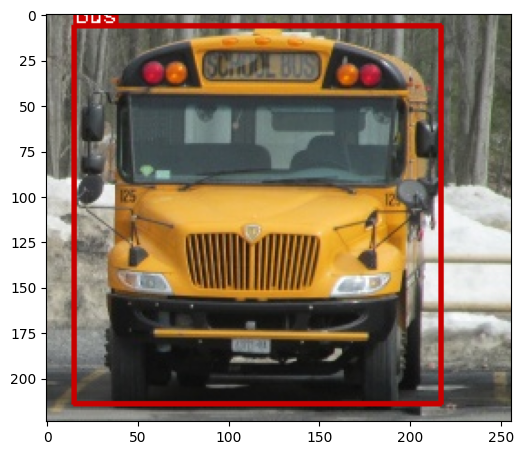

In [80]:
boxes = target['boxes'].numpy()
class_ids = target['labels'].numpy()
n_obj = boxes.shape[0]
bboxes = np.zeros(shape=(n_obj, 4), dtype=np.float32)
bboxes[:, 0:2] = (boxes[:, 0:2] + boxes[:, 2:4]) / 2
bboxes[:, 2:4] = boxes[:, 2:4] - boxes[:, 0:2]

canvas = visualize(image, bboxes, class_ids)
plt.figure(figsize=(6, 6))
plt.imshow(canvas)
plt.show()

In [81]:
@interact(index=(0, len(image_files)-1))
def show_sample(index=0):
    image, target, filename = dataset[index]
    boxes = target['boxes'].numpy()
    class_ids = target['labels'].numpy()
    n_obj = boxes.shape[0]
    bboxes = np.zeros(shape=(n_obj, 4), dtype=np.float32)
    bboxes[:, 0:2] = (boxes[:, 0:2] + boxes[:, 2:4]) / 2
    bboxes[:, 2:4] = boxes[:, 2:4] - boxes[:, 0:2]
    
    canvas = visualize(image, bboxes, class_ids)
    plt.figure(figsize=(6, 6))
    plt.imshow(canvas)
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=13702), Output()), _dom_classes=('widget-int…

In [29]:
IMAGE_SIZE = 448

# [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]
# pretraining에 사용된 ImageNet 데이터셋의 학습시에 얻어낸 값(평균, 표준편차)
transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [30]:
data_dir = './datasets/'
transformed_dataset = Detection_dataset(data_dir=data_dir, phase='train', transformer=transformer)

In [31]:
index = 20
image, target, filename = transformed_dataset[index]
image.shape

torch.Size([3, 448, 448])

In [32]:
np_image = make_grid(image, normalize=True).cpu().permute(1, 2, 0).numpy()
np_image.shape

(448, 448, 3)

In [33]:
boxes = target['boxes'].numpy()
class_ids = target['labels'].numpy()
n_obj = boxes.shape[0]

In [34]:
boxes

array([[300.57755, 228.37068, 318.5961 , 249.1319 ],
       [370.1936 , 355.12198, 447.18106, 408.66336]], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


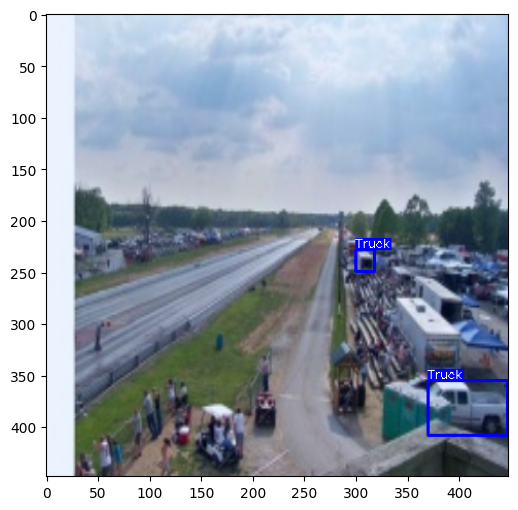

In [35]:
bboxes = np.zeros(shape=(n_obj, 4), dtype=np.float32)
bboxes[:, 0:2] = (boxes[:, 0:2] + boxes[:, 2:4]) / 2
bboxes[:, 2:4] = boxes[:, 2:4] - boxes[:, 0:2]

canvas = visualize(np_image, bboxes, class_ids)
plt.figure(figsize=(6, 6))
plt.imshow(canvas)
plt.show()

In [36]:
# collate_fn: 파이토치에서 데이터셋을 미니배치로 묶는 함수
# 파이토치의 데이터로더를 사용하여 데이터를 불러올 때 각각의 샘플을 미니배치로 묶을 때 어떻게
# 처리할지를 정의하는 함수
def collate_fn(batch):
    image_list = []
    target_list = []
    filename_list = []
    for img, target, filename in batch:
        image_list.append(img)
        target_list.append(target)
        filename_list.append(filename)
    return image_list, target_list, filename_list

In [37]:
BATCH_SIZE = 8
trainset = Detection_dataset(data_dir=data_dir, phase='train', transformer=transformer)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)

In [38]:
for index, batch in enumerate(trainloader):
    images = batch[0]
    targets = batch[1]
    filenames = batch[2]

    if index == 0:
        break

print(targets, filenames)

[{'boxes': tensor([[ 47.0427,  62.9543, 409.1624, 428.9672],
        [300.3078,  98.0914, 447.4530, 359.4250]]), 'labels': tensor([1, 1])}, {'boxes': tensor([[307.7200,  14.3427, 439.0400, 443.3596]]), 'labels': tensor([1])}, {'boxes': tensor([[  8.1200,  26.1605, 437.6400, 397.3137]]), 'labels': tensor([0])}, {'boxes': tensor([[ 10.2399, 282.2261, 170.2400, 344.7911]]), 'labels': tensor([1])}, {'boxes': tensor([[ 85.9600,  74.2932, 387.5200, 394.9868]]), 'labels': tensor([0])}, {'boxes': tensor([[114.5200, 382.6668, 155.6800, 418.1332],
        [173.0400, 351.6800, 295.6800, 447.6268],
        [350.2800, 356.5332, 447.7200, 447.6268]]), 'labels': tensor([0, 0, 0])}, {'boxes': tensor([[2.8000e-01, 6.3786e+00, 4.4296e+02, 4.2999e+02]]), 'labels': tensor([0])}, {'boxes': tensor([[ 69.1600, 116.8532, 403.4800, 378.5600],
        [  4.4800, 189.2800,  58.8000, 256.4800],
        [ 51.2400, 145.9732, 145.6000, 285.6000],
        [357.2800, 149.7068, 447.7200, 294.9332]]), 'labels': tensor([

In [39]:
def build_dataloader(data_dir, batch_size=4, image_size=448):
    transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(size=(IMAGE_SIZE, IMAGE_SIZE)),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    dataloaders = {}
    train_dataset = Detection_dataset(data_dir=data_dir, phase='train', transformer=transformer)
    dataloaders['train'] = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    val_dataset = Detection_dataset(data_dir=data_dir, phase='val', transformer=transformer)
    dataloaders['val'] = DataLoader(val_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)
    return dataloaders

In [40]:
data_dir = './datasets/'
dloaders = build_dataloader(data_dir)

for phase in ['train', 'val']:
    for index, batch in enumerate(dloaders[phase]):
        images = batch[0]
        targets = batch[1]
        filenames = batch[2]
        print(targets)
        if index == 0:
            break

[{'boxes': tensor([[ 69.1600, 262.7368,  82.3200, 354.9473],
        [ 79.2400, 180.6318, 291.7600, 430.7368],
        [262.3600, 270.3156, 391.7200, 317.0527],
        [387.5200, 276.2104, 400.6800, 290.9473],
        [400.6800, 269.4738, 437.0800, 306.5265]]), 'labels': tensor([0, 0, 0, 0, 0])}, {'boxes': tensor([[104.4400, 108.3125, 330.6800, 420.1846]]), 'labels': tensor([1])}, {'boxes': tensor([[ 21.8400,  62.8548, 427.5600, 338.7422]]), 'labels': tensor([1])}, {'boxes': tensor([[ 49.0000, 148.9152, 406.8400, 325.8564]]), 'labels': tensor([1])}]
[{'boxes': tensor([[ 80.9200, 186.5965, 303.5200, 393.7862]]), 'labels': tensor([1])}]


# Two-stage 모델
* 탐색 영역을 찾는 Region Proposal과 해당 영역을 분류하는 Detection 두 가지 과정이 순차적으로 수행되는 방법
* 위치를 찾는 문제(Localization)
  * 하나의 이미지 안에서 물체가 있을법한 위치를 찾아 나열하는 과정에 대한 정보를 제안
* 분류 문제(Classification)
  * 각각의 위치에 대해 class를 분류
  * 이미지 내의 사물에 존재하는 bounding box를 예측하는 regression 사용

### R-CNN
* Selective Search를 이용해 2,000개의 ROI를 추출
* 각 ROI에 대하여 동일한 크기의 입력 이미지로 변경
* 이미지를 CNN에 넣어서 벡터 이미지를 추출
* 해당 feature를 SVM에 넣어 class 분류 결과를 얻음
* 입력 이미지에 대해 CPU 기반의 Selective Search를 진행하므로 많은 시간이 소요

### Fast R-CNN
* 동일한 Region Proposal을 이용하지만 이미지를 한 번만 CNN에 넣어 Feature Map을 생성
* Region Proposal: 물체가 있을 법한 위치를 찾기
* 입력 이미지에 대해 CPU 기반의 Selective Search를 진행하므로 많은 시간이 소요

### Faster R-CNN
* 병목에 해당하던 Region Proposal 작업을 GPU를 통해서 수행함
* 슬라이딩 윈도우를 거쳐 각 위치에 대해 Regression과 Classification을 수행

# One-Stage 모델
* Region Proposal과 Detection이 한 번에 수행
* YOLO(You Only Look Once): 2015년 제안된 객체 검출 모델로 이미지 전체를 단일 그리드로 나누고, 각 그리드 셀마다 여러 개의 바운딩 박스와 클래스를 예측하는 방식

# Faster R-CNN (ResNet50)
* ResNet50은 Faster R-CNN를 사용하여 FPN(다양한 크기의 객체를 효과적으로 탐지하기 위한 기술)을 사용한 모델

In [41]:
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [42]:
def build_model(num_classes):
    model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # FastRCNNPredictor(): Faster R-CNN 모델의 마지막 분류기를 변경하기 위한 함수
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [43]:
NUM_CLASSES = 2
model = build_model(num_classes=NUM_CLASSES)
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [44]:
phase = 'train'
model.train()

for index, batch in enumerate(dloaders[phase]):
    images = batch[0]
    targets = batch[1]
    filenames = batch[2]

    images = list(image for image in images)
    targets = [{k: v for k, v in t.items()} for t in targets]

    loss = model(images, targets)
    if index == 0:
        break

In [45]:
loss

{'loss_classifier': tensor(0.7651, grad_fn=<NllLossBackward0>),
 'loss_box_reg': tensor(0.1177, grad_fn=<DivBackward0>),
 'loss_objectness': tensor(0.1876, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>),
 'loss_rpn_box_reg': tensor(0.0134, grad_fn=<DivBackward0>)}

* loss_classifier: 객체 탐지 모델에서 분류기의 손실 함수. 객체의 종류를 예측하는데 사용
* loss_box_reg: 객체 위치를 예측하는 박스 회귀 모델의 손실 함수. 예측된 경계 상자의 위치와 실제 객체의 위치 사이의 차이를 줄이기 위해 사용
* loss_objectness: 객체 탐지 모델에서 사용되는 개체 존재 여부를 예측하는데 사용되는 손실 함수. 각 경계 상자에 대해 해당 상자에 객체가 존재하는 여부를 예측하고 실제와 비교하여 학습
* loss_rpn_box_reg: RPN의 박스 회귀 손실 함수. 객체 후보 영역을 제안하고 이 후보 영역의 경계 상자를 조정하기 위해 사용

In [46]:
def train_one_epoch(dataloaders, model, optimizer, device):
    train_loss = defaultdict(float)
    val_loss = defaultdict(float)
    model.train()

    for phase in ['train', 'val']:
        for index, batch in enumerate(dataloaders[phase]):
            images = batch[0]
            targets = batch[1]
            filenames = batch[2]

            images = list(image for image in images)
            targets = [{k: v for k, v in t.items()} for t in targets]

            with torch.set_grad_enabled(phase == 'train'):
                loss = model(images, targets)
        total_loss = sum(each_loss for each_loss in loss.values())

        if phase == 'train':
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

            if (index > 0) and (index % VERBOSE_FREQ == 0):
                text = f"{index}/{len(dataloaders[phase])} - "
                for k, v in loss.items():
                    text += f'{k}: {v.item():.4f} '
                print(text)

            for k, v in loss.items():
                train_loss[k] += v.item()
            train_loss['total_loss'] += total_loss.item()
        else:
            for k, v in loss.items():
                val_loss[k] += v.item()
            val_loss['total_loss'] += total_loss.item()

    for k in train_loss.keys():
        train_loss[k] /= len(dataloaders['train'])
        val_loss[k] /= len(dataloaders['val'])
    return train_loss, val_loss

In [47]:
data_dir = './datasets/'
is_cuda = False

NUM_CLASSES = 2
IMAGE_SIZE = 448
BATCH_SIZE = 8
VERBOSE_FREQ = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available and is_cuda else 'cpu')

dataloaders = build_dataloader(data_dir=data_dir, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE)
model = build_model(num_classes=NUM_CLASSES)
model = model.to(DEVICE)
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [48]:
# num_epochs = 30
# train_losses = []
# val_losses=[]

# for epoch in range(num_epochs):
#     train_loss, val_loss = train_one_epoch(dataloaders, model, optimizer, DEVICE)
#     train_losses.append(train_loss)
#     val_losses.append(val_loss)

#     print(f"epoch:{epoch+1}/{num_epochs} - Train Loss: {train_loss['total_loss']:.4f}, Val Loss: {val_loss['total_loss']:.4f}")
#     if(epoch+1) % 10 == 0:
#         save_model(model.stat_dict(), f'model_{epoch+1}.pth')

In [49]:
# tr_loss_classifier = []
# tr_loss_box_reg = []
# tr_loss_objectness = []
# tr_loss_rpn_box_reg = []
# tr_loss_total = []

# for tr_loss in train_losses:
#     tr_loss_classifier.append(tr_loss['loss_classifier'])
#     tr_loss_box_reg.append(tr_loss['loss_box_reg'])
#     tr_loss_objectness.append(tr_loss['loss_objectness'])
#     tr_loss_rpn_box_reg.append(tr_loss['loss_rpn_box_reg'])
#     tr_loss_total.append(tr_loss['total_loss'])

# val_loss_classifier = []
# val_loss_box_reg = []
# val_loss_objectness = []
# val_loss_rpn_box_reg = []
# val_loss_total = []

# for vl_loss in val_losses:
#     val_loss_classifier.append(vl_loss['loss_classifier'])
#     val_loss_box_reg.append(vl_loss['loss_box_reg'])
#     val_loss_objectness.append(vl_loss['loss_objectness'])
#     val_loss_rpn_box_reg.append(vl_loss['loss_rpn_box_reg'])
#     val_loss_total.append(vl_loss['total_loss'])

In [50]:
# plt.figure(figsize=(8, 4))
# plt.plot(tr_loss_total, label="train_total_loss")
# plt.plot(tr_loss_classifier, label="train_loss_classifier")
# plt.plot(tr_loss_box_reg,  label="train_loss_box_reg")
# plt.plot(tr_loss_objectness, label="train_loss_objectness")
# plt.plot(tr_loss_rpn_box_reg,  label="train_loss_rpn_box_reg")

# plt.plot(val_loss_total, label="val_total_loss")
# plt.plot(val_loss_classifier, label="val_loss_classifier")
# plt.plot(val_loss_box_reg,  label="val_loss_box_reg")
# plt.plot(val_loss_objectness, label="val_loss_objectness")
# plt.plot(val_loss_rpn_box_reg,  label="val_loss_rpn_box_reg")
# plt.xlabel("epoch")
# plt.ylabel("loss")
# plt.grid("on")
# plt.legend(loc='upper right')
# plt.tight_layout()

In [51]:
def load_model(ckpt_path, num_classes, device):
    checkpoint = torch.load(ckpt_path, map_location=device)
    model = build_model(num_classes=num_classes)
    model.load_state_dict(checkpoint)
    model = model.to(device)
    model.eval()
    return model

In [52]:
model = load_model(ckpt_path='./trained_model/model_30.pth', num_classes=NUM_CLASSES, device=DEVICE)
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

# Confidence Threshold
* 객체 탐지와 같은 작업에서 사용되는 개념
* 객체 탐지 모델은 입력 이미지에서 객체의 위치를 찾아내는 작업을 수행 -> 모델은 주어진 이미지 내에서 다양한 위치에 대해 객체가 존재하는지 예측하고 각 객체에 대한 바운딩 박스와 해당 객체에 대한 신뢰도(Confidence Score)를 출력
* Confidence Threshold: 신뢰도를 조절하는 기준 값
* Confidence Threshold를 0.6로 설정하면 모델은 신뢰도가 0.6이상인 객체만을 선택하게 됨
* Confidence Threshold를 적절하게 설정해야 객체 탐지의 정확도를 높일 수 있음
* 너무 낮은 Confidence Threshold를 설정하면 신뢰성이 낮은 결과를 포함할 수 있고, 너무 높은 Confidence Threshold를 설정하면 신뢰성이 높은 객체조차 누락

<img src='https://blog.kakaocdn.net/dn/96Xcc/btrAaVSmJqg/K69oluJU7oCqNHntQ8wh20/img.png' width='300'>

# Non-Maximum Suppression(NMS)
* 중복된 결과를 제거하여 정확하고 겹치지 않는 객체를 식별하는 데 사용
* 바운딩 박스 필터링(겹치는 바운딩 박스들 중에서 가장 확실한 바운딩 박스만 남기고 나머지 겹치는 바운딩 박스를 제거(IoU 지표를 사용)

# IoU(Intersection over Union)
* 객체 탐지나 세그멘테이션과 같은 컴퓨터 비전에서 모델이 예측한 결과와 실제 라벨 사이의 정확도를 측정하는 지표
* 바운딩 박스나 세그멘테이션 마스크가 얼마나 겹치는지를 측정하여, 예측 결과의 정확성을 평가하는데 사용
* 0과 1사이의 값으로 1에 가까울수록 예측 결과가 정확하고 겹치는 영역이 많다는 것을 의미
* 계산 방법
  * 영역 A와 영역 B의 겹치는 영역 계산 -> 공통 부분을 계산
  * 교집합 계산(얼마나 겹쳐져 있는지)
  * 합집합 계산(두 영역의 전체 크기)
  * 교집합을 합집합으로 나눔 -> 교집합 / 합집합(IoU 계산)

In [53]:
def postprocess(prediction, conf_thres=0.4, IoU_threshold=0.4):
    pred_box = prediction['boxes'].cpu().detach().numpy()
    pred_label = prediction['labels'].cpu().detach().numpy()
    pred_conf = prediction['scores'].cpu().detach().numpy()

    valid_index = pred_conf > conf_thres
    pred_box = pred_box[valid_index]
    pred_label = pred_label[valid_index]
    pred_conf = pred_conf[valid_index]
    return np.concatenate((pred_box, pred_conf[:, np.newaxis], pred_label[:, np.newaxis]), axis=1)

In [54]:
pred_images = []
pred_labels = []

for index, (images, _, filenames) in enumerate(dataloaders['val']):
    images = list(image.to(DEVICE) for image in images)
    filename = filenames[0]

    image = make_grid(images[0].cpu().detach(), normalize=True).permute(1, 2, 0).numpy()
    image = (image * 255).astype(np.uint8)

    with torch.no_grad():
        prediction = model(images)

    prediction = postprocess(prediction[0])
    prediction[:, 2].clip(min=0, max=image.shape[1])
    prediction[:, 3].clip(min=0, max=image.shape[0])

    xc = (prediction[:, 0] + prediction[:, 2])/2
    yc = (prediction[:, 1] + prediction[:, 3])/2
    w = prediction[:, 2] - prediction[:, 0]
    h = prediction[:, 3] - prediction[:, 1]
    cls_id = prediction[:, 5]
    prediction_yolo = np.stack([xc, yc, w, h, cls_id], axis=1)

    pred_images.append(image)
    pred_labels.append(prediction_yolo)

    if index == 2:
        break

In [55]:
pred_labels

[array([[188.43429565, 290.40631866, 211.487854  , 200.54057312,
           1.        ]]),
 array([[208.22994995, 197.66025543,  88.45446777,  52.08399963,
           1.        ],
        [412.11094666, 194.3682251 ,  64.59024048,  43.08612061,
           1.        ],
        [ 39.46678495, 256.96799469,  76.92488956, 246.36082458,
           1.        ]]),
 array([[299.85534668, 290.83686829, 176.81842041, 232.45474243,
           1.        ]])]

In [56]:
@interact(index=(0, len(pred_images)-1))
def show_result(index=0):
    result = visualize(pred_images[index], pred_labels[index][:, 0:4], pred_labels[index][:, 4])
    plt.figure(figsize=(6, 6))
    plt.imshow(result)
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=2), Output()), _dom_classes=('widget-interac…

In [57]:
video_path = './sample_video.mp4'

In [58]:
@torch.no_grad()
def model_predict(image, model):
    tensor_image = transformer(image)
    tensor_image = tensor_image.to(DEVICE)
    prediction = model([tensor_image])
    return prediction

In [59]:
video = cv2.VideoCapture(video_path)

In [60]:
while(video.isOpened()):
    ret, frame = video.read()
    if ret:
        ori_h, ori_w = frame.shape[:2]
        image = cv2.resize(frame, dsize=(IMAGE_SIZE, IMAGE_SIZE))
        prediction = model_predict(image, model)
        prediction = postprocess(prediction[0])

        prediction[:, [0, 2]] *= (ori_w / IMAGE_SIZE)
        prediction[:, [1, 3]] *= (ori_h / IMAGE_SIZE)
        prediction[:, 2].clip(min=0, max=image.shape[1])
        prediction[:, 3].clip(min=0, max=image.shape[0])

        xc = (prediction[:, 0] + prediction[:, 2])/2
        yc = (prediction[:, 1] + prediction[:, 3])/2
        w = prediction[:, 2] - prediction[:, 0]
        h = prediction[:, 3] - prediction[:, 1]
        cls_id = prediction[:, 5]
        prediction_yolo = np.stack([xc, yc, w, h, cls_id], axis=1)

        canvas = visualize(frame, prediction_yolo[:, 0:4], prediction_yolo[:, 4])
        cv2.imshow('camera', canvas)
        
        key = cv2.waitKey(1)
        if key == 27:
            break
        if key == ord('s'):
            cv2.waitKey()

video.release()

error: OpenCV(4.9.0) D:\a\opencv-python\opencv-python\opencv\modules\highgui\src\window.cpp:1272: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'
